In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datalab_utils
import astropy.units as u
import os

from dl import authClient as ac, queryClient as qc
from collections import Counter
from tqdm import tqdm
from matplotlib.colors import LogNorm

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
base_dir = "/dlusers/adriansh/work/analyses/"
fig_dir = os.path.join(base_dir, "plots/strings/19june2024/")
results_dir = os.path.join(base_dir, "results/strings/19june2024/")

In [2]:
def count_samples(df):
    n_samples = len(df)
    n_baseline = df["cluster_label"].sum()
    n_bright = n_samples - n_baseline
    data = {"n_baseline": [n_baseline], "n_bright": [n_bright]}
    result = pd.DataFrame(data=data, index=[df.iloc[0, 0]])
    return result

def is_multichromatic(s):
    vals = Counter(s).values()
    result = (len(vals) > 1) and ((np.array(list(vals)) > 1).all())
    return result

def biggest_diff(chars):
    filters = ['u', 'g', 'r', 'i', 'z', 'Y']
    vals = np.arange(len(filters))
    f_dict = dict(zip(filters, vals))
    x = np.array([f_dict[k] for k in list(set(chars))])
    result = x.max() - x.min()
    return result

def finite_average_delta_t(s):

    if np.isfinite(s["t_start_max"]):
        ts_max = s["t_start_max"]
    else:
        ts_max = s["t_start_min"]

    if np.isfinite(s["t_end_max"]):
        te_max = s["t_end_max"]
    else:
        te_max = s["t_end_min"]

    ts_min = s["t_start_min"]
    te_min = s["t_end_min"]
    result = ((te_max - ts_max) + (te_min - ts_min)) / 2
    return result

In [3]:
lc_df_all = pd.concat([pd.read_parquet(f"{results_dir}lightcurves_batch{i}.parquet") for i in range(17)], ignore_index=True)
time_df_all = pd.concat([pd.read_parquet(f"{results_dir}times_batch{i}.parquet") for i in range(17)], ignore_index=True)

lc_df_all = lc_df_all.groupby(by="objectid").filter(lambda x: len(x) >= 400)

In [8]:
g_id = lc_df_all.groupby(by="objectid")

In [11]:
id_df = g_id.get_group("181736_42318")

In [12]:
g_f = id_df.groupby(by="filter")

In [14]:
idxs = id_df.index

In [15]:
idxs

Index([186996, 187316, 187522, 187661, 187808, 188069, 188196, 188557, 188766,
       188917,
       ...
       542225, 542588, 542725, 542809, 543193, 543412, 543524, 543809, 543952,
       544181],
      dtype='int64', length=1001)

In [21]:
g_f.get_group("r").index[np.isin(g_f.get_group("r").index, idxs[:10])]

Index([187661, 188917], dtype='int64')

In [4]:
lc_df_achromatic = lc_df_all.groupby("objectid").filter(lambda group: datalab_utils.lens_filter(group, achromatic=True, factor_of_two=False))
lc_df_achromatic_factor = lc_df_all.groupby("objectid").filter(lambda group: datalab_utils.lens_filter(group, achromatic=True, factor_of_two=True))

results_df_all = datalab_utils.make_lensing_dataframe(lc_df_all)
results_df_achromatic = datalab_utils.make_lensing_dataframe(lc_df_achromatic)
results_df_achromatic_factor = datalab_utils.make_lensing_dataframe(lc_df_achromatic_factor)

filter_diffs_all = results_df_all["filters"].apply(biggest_diff)
filter_diffs_achromatic = results_df_achromatic["filters"].apply(biggest_diff)
filter_diffs_achromatic_factor = results_df_achromatic_factor["filters"].apply(biggest_diff)

n_samples_all = lc_df_all.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_all.index.name = "objectid"
n_samples_achromatic = lc_df_all.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_achromatic.index.name = "objectid"
n_samples_achromatic_factor = lc_df_all.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_achromatic_factor.index.name = "objectid"

results_df_all = results_df_all.assign(achromatic=results_df_all["filters"].apply(lambda x: len(set(x)) > 1),
                                       delta_t_max=lambda x: x["t_end_max"] - x["t_start_max"],
                                       delta_t_min=lambda x: x["t_end_min"] - x["t_start_min"],
                                       multiplicity_2=results_df_all["filters"].apply(is_multichromatic),
                                       n_bright=results_df_all["filters"].apply(lambda x: len(x)))
results_df_achromatic = results_df_achromatic.assign(achromatic=results_df_achromatic["filters"].apply(lambda x: len(set(x)) > 1),
                                                     delta_t_max=lambda x: x["t_end_max"] - x["t_start_max"],
                                                     delta_t_min=lambda x: x["t_end_min"] - x["t_start_min"],
                                                     multiplicity_2=results_df_achromatic["filters"].apply(is_multichromatic),
                                                     n_bright=results_df_achromatic["filters"].apply(lambda x: len(x)))
results_df_achromatic_factor = results_df_achromatic_factor.assign(achromatic=results_df_achromatic_factor["filters"].apply(lambda x: len(set(x)) > 1),
                                                                   delta_t_max=lambda x: x["t_end_max"] - x["t_start_max"],
                                                                   delta_t_min=lambda x: x["t_end_min"] - x["t_start_min"],
                                                                   multiplicity_2=results_df_achromatic_factor["filters"].apply(is_multichromatic),
                                                                   n_bright=results_df_achromatic_factor["filters"].apply(lambda x: len(x)))

In [5]:
results_df_all["delta_t_av"] = (results_df_all["delta_t_max"] + results_df_all["delta_t_min"]) / 2
results_df_achromatic["delta_t_av"] = (results_df_achromatic["delta_t_max"] + results_df_achromatic["delta_t_min"]) / 2
results_df_achromatic_factor["delta_t_av"] = (results_df_achromatic_factor["delta_t_max"] + 
                                              results_df_achromatic_factor["delta_t_min"]) / 2

In [6]:
n_events_all = results_df_all.groupby(level=0).filters.agg("count")
n_events_achromatic = results_df_achromatic.groupby(level=0).filters.agg("count")
n_events_achromatic_factor = results_df_achromatic_factor.groupby(level=0).filters.agg("count")

n_events_all.name = "n_events"
n_events_achromatic.name = "n_events"
n_events_achromatic_factor.name = "n_events"

lc_df_all.sort_values(by="objectid", inplace=True)
lc_df_achromatic.sort_values(by="objectid", inplace=True)
lc_df_achromatic_factor.sort_values(by="objectid", inplace=True)

results_df_all.sort_index(level=0, inplace=True)
results_df_achromatic.sort_index(level=0, inplace=True)
results_df_achromatic_factor.sort_index(level=0, inplace=True)

n_events_all.sort_index(inplace=True)
n_events_achromatic.sort_index(inplace=True)
n_events_achromatic_factor.sort_index(inplace=True)

In [7]:
taus = np.geomspace(1e-4, 1e4, num=50)

cadence_results_all = {f"{n}": np.zeros((2, taus.size)) for n in n_events_all.value_counts().index}
n_samples_x_all = np.arange(0, n_events_all.max()+1)
n_samples_y_all = np.zeros(n_samples_x_all.shape)
n_bright_y_all = np.zeros(n_samples_x_all.shape)
g_lc = lc_df_all.groupby(by="objectid", sort=False)
g_res = results_df_all.groupby(level=0, sort=False)

for (name1, lc), (name2, res), idx in zip(g_lc, g_res, n_events_all.index):
    assert name1 == name2 == idx
    nev = n_events_all.loc[idx]
    cadence_results_all[f"{nev}"][0] += datalab_utils.measure_time(lc, taus)
    n_samples_y_all[nev] += len(lc)
    n_bright_y_all[nev] += res["n_bright"].sum()
    h, _ = np.histogram(res["delta_t_av"], bins=taus)
    n_infinite = sum(~np.isfinite(res["delta_t_av"]))
    cadence_results_all[f"{nev}"][1, :-1] += h
    cadence_results_all[f"{nev}"][1, -1] += n_infinite

In [8]:
cadence_results_achromatic = {f"{n}": np.zeros((2, taus.size)) for n in n_events_achromatic.value_counts().index}
n_samples_x_achromatic = np.arange(0, n_events_achromatic.max()+1)
n_samples_y_achromatic = np.zeros(n_samples_x_achromatic.shape)
n_bright_y_achromatic = np.zeros(n_samples_x_achromatic.shape)
g_lc = lc_df_achromatic.groupby(by="objectid", sort=False)
g_res = results_df_achromatic.groupby(level=0, sort=False)

for (name1, lc), (name2, res), idx in zip(g_lc, g_res, n_events_achromatic.index):
    assert name1 == name2 == idx
    nev = n_events_achromatic.loc[idx]
    cadence_results_achromatic[f"{nev}"][0] += datalab_utils.measure_time(lc, taus)
    n_samples_y_achromatic[nev] += len(lc)
    n_bright_y_achromatic[nev] += res["n_bright"].sum()
    h, _ = np.histogram(res["delta_t_av"], bins=taus)
    n_infinite = sum(~np.isfinite(res["delta_t_av"]))
    cadence_results_achromatic[f"{nev}"][1, :-1] += h
    cadence_results_achromatic[f"{nev}"][1, -1] += n_infinite

In [9]:
cadence_results_achromatic_factor = {f"{n}": np.zeros((2, taus.size)) for n in n_events_achromatic_factor.value_counts().index}
n_samples_x_achromatic_factor = np.arange(0, n_events_achromatic_factor.max()+1)
n_samples_y_achromatic_factor = np.zeros(n_samples_x_achromatic_factor.shape)
n_bright_y_achromatic_factor = np.zeros(n_samples_x_achromatic_factor.shape)
g_lc = lc_df_achromatic_factor.groupby(by="objectid", sort=False)
g_res = results_df_achromatic_factor.groupby(level=0, sort=False)

for (name1, lc), (name2, res), idx in zip(g_lc, g_res, n_events_achromatic_factor.index):
    assert name1 == name2 == idx
    nev = n_events_achromatic_factor.loc[idx]
    cadence_results_achromatic_factor[f"{nev}"][0] += datalab_utils.measure_time(lc, taus)
    n_samples_y_achromatic_factor[nev] += len(lc)
    n_bright_y_achromatic_factor[nev] += res["n_bright"].sum()
    h, _ = np.histogram(res["delta_t_av"], bins=taus)
    n_infinite = sum(~np.isfinite(res["delta_t_av"]))
    cadence_results_achromatic_factor[f"{nev}"][1, :-1] += h
    cadence_results_achromatic_factor[f"{nev}"][1, -1] += n_infinite

In [10]:
filters_in_event_all = results_df_all["filters"].apply(lambda x: "".join(sorted(set(x))))
filters_in_event_achromatic = results_df_achromatic["filters"].apply(lambda x: "".join(sorted(set(x))))
filters_in_event_achromatic_factor = results_df_achromatic_factor["filters"].apply(lambda x: "".join(sorted(set(x))))

filters_in_event_hist_all = filters_in_event_all.value_counts()
filters_in_event_hist_achromatic = filters_in_event_achromatic.value_counts()
filters_in_event_hist_achromatic_factor = filters_in_event_achromatic_factor.value_counts()

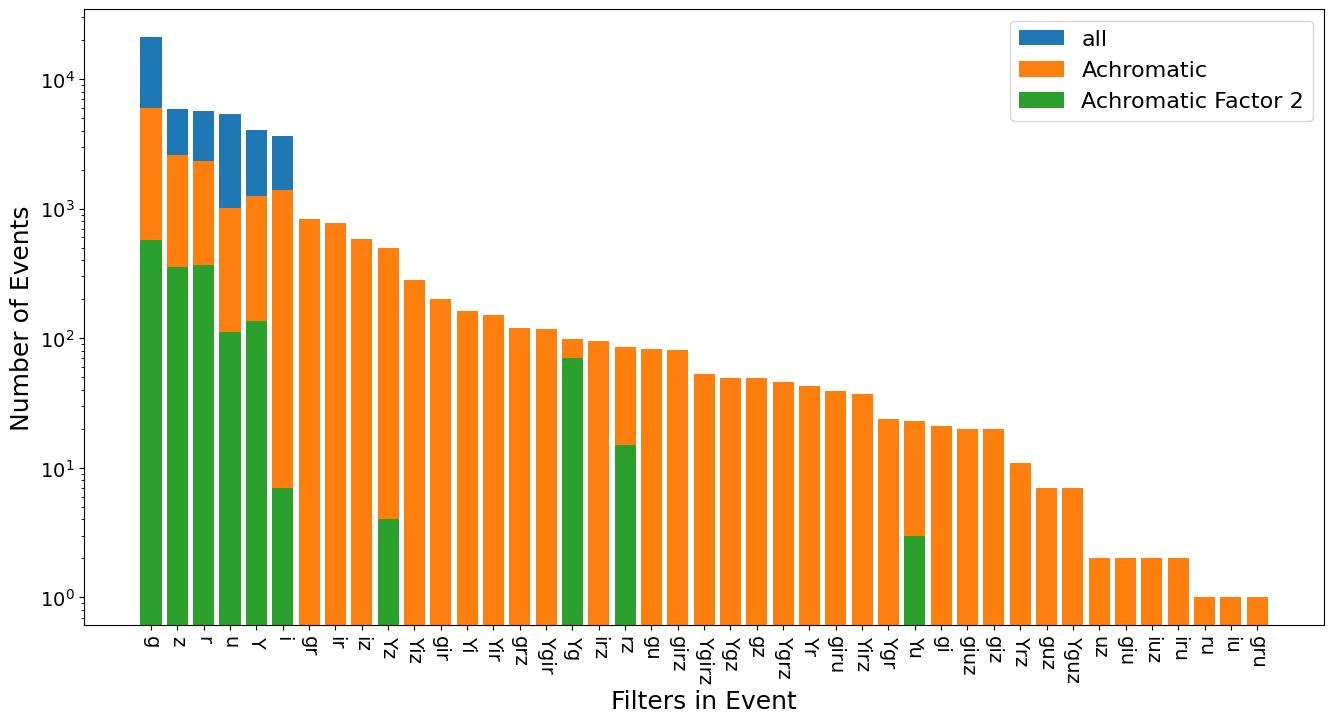

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(filters_in_event_hist_all.index, filters_in_event_hist_all, label="all")
ax.bar(filters_in_event_hist_achromatic.index, filters_in_event_hist_achromatic, label="Achromatic")
ax.bar(filters_in_event_hist_achromatic_factor.index, filters_in_event_hist_achromatic_factor, label="Achromatic Factor 2")
ax.set_yscale("log")
ax.set_xlabel("Filters in Event", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
fig.savefig(f"{fig_dir}filters_in_event.png")
plt.show(fig)

In [12]:
n_events_per_source_all = results_df_all.groupby(level=0).t_start_max.agg("count")
n_events_per_source_achromatic = results_df_achromatic.groupby(level=0).t_start_max.agg("count")
n_events_per_source_achromatic_factor = results_df_achromatic_factor.groupby(level=0).t_start_max.agg("count")

In [13]:
n_events_freq_all = n_events_per_source_all.value_counts()
n_events_freq_achromatic = n_events_per_source_achromatic.value_counts()
n_events_freq_achromatic_factor = n_events_per_source_achromatic_factor.value_counts()

n_events_freq_all.index.name = "n_events"
n_events_freq_achromatic.index.name = "n_events"
n_events_freq_achromatic_factor.index.name = "n_events"

In [14]:
n_events_freq_all.name = "all"
n_events_freq_achromatic.name = "achromatic"
n_events_freq_achromatic_factor.name = "achromatic_factor2"
temp = pd.Series(np.zeros(n_events_freq_all.index.max() + 1), name="temp")

n_events_freq_df = pd.concat([n_events_freq_all, n_events_freq_achromatic, 
                              n_events_freq_achromatic_factor, temp], axis=1)
n_events_freq_df.index.name = "n_events"
n_events_freq_df.replace(np.nan, 0, inplace=True)
n_events_freq_df.sort_index(inplace=True)
n_events_freq_df.drop(columns="temp", inplace=True)

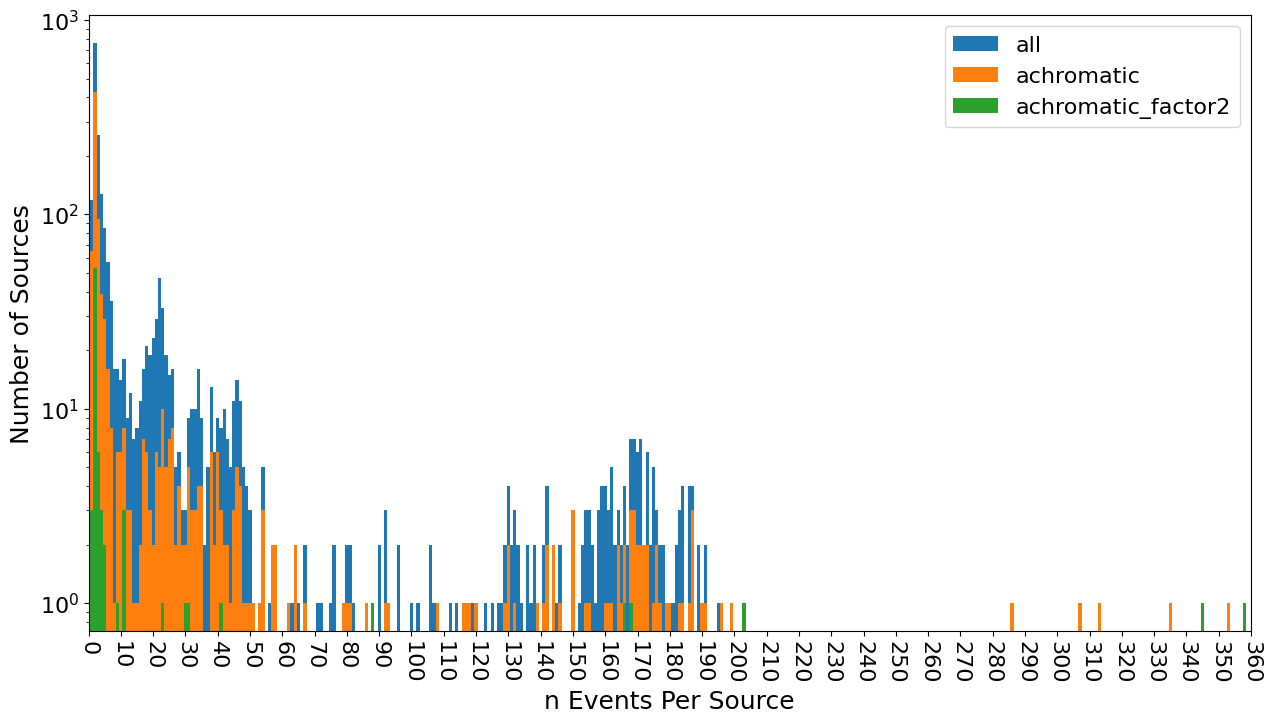

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
x_ticks = np.arange(0, 10 * np.ceil(n_events_freq_df.index.max() / 10) + 10, 10).astype(int)

for col in n_events_freq_df.columns:
    x = n_events_freq_df[col].index.values
    y = n_events_freq_df[col].values
    ax.bar(x, y, width=1, label=col)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=-90)
ax.set_xlim((x_ticks.min(), x_ticks.max()))
ax.legend(loc="upper right", fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n Events Per Source", fontsize=18)
ax.set_ylabel("Number of Sources", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}events_per_source_hist_well_sampled.png")
plt.show(fig)

In [19]:
n_events_freq_df

,all,achromatic,achromatic_factor2
n_events,,,
0,0.0,0.0,0.0
1,119.0,65.0,3.0
2,761.0,424.0,53.0
3,256.0,95.0,6.0
4,127.0,39.0,3.0
...,...,...,...
354,0.0,0.0,0.0
355,0.0,0.0,0.0
356,0.0,0.0,0.0


In [17]:
n_events_freq_df.sum(axis=0)

all                   2194.0
achromatic             919.0
achromatic_factor2      81.0
dtype: float64

In [20]:
3 / 2194

0.0013673655423883319

In [50]:
n_sources_per_n_events_all = np.full(n_samples_y_all.shape, np.nan)
n_sources_per_n_events_all[n_events_freq_df["all"].index] = n_events_freq_df["all"]
np.place(n_sources_per_n_events_all, n_sources_per_n_events_all < 1, np.nan)
n_samples_per_source_all = n_samples_y_all / n_sources_per_n_events_all

n_sources_per_n_events_achromatic = np.full(n_samples_y_achromatic.shape, np.nan)
n_sources_per_n_events_achromatic[n_events_freq_df["achromatic"].index] = n_events_freq_df["achromatic"]
np.place(n_sources_per_n_events_achromatic, n_sources_per_n_events_achromatic < 1, np.nan)
n_samples_per_source_achromatic = n_samples_y_achromatic / n_sources_per_n_events_achromatic

n_sources_per_n_events_achromatic_factor = np.full(n_samples_y_achromatic_factor.shape, np.nan)
n_sources_per_n_events_achromatic_factor[n_events_freq_df["achromatic_factor2"].index] = n_events_freq_df["achromatic_factor2"]
np.place(n_sources_per_n_events_achromatic_factor, n_sources_per_n_events_achromatic_factor < 1, np.nan)
n_samples_per_source_achromatic_factor = n_samples_y_achromatic_factor / n_sources_per_n_events_achromatic_factor

In [51]:
normalizing_curve_all = n_samples_per_source_all[50] * n_samples_x_all / 50

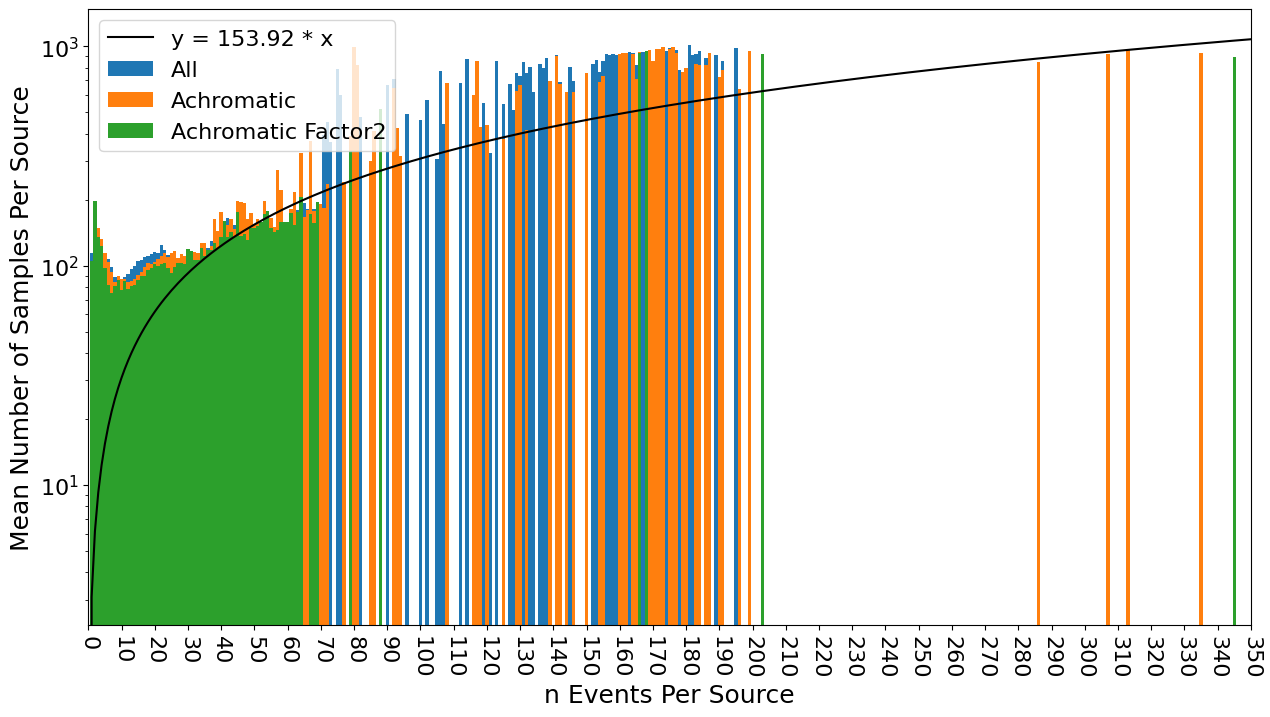

In [52]:
fig, ax = plt.subplots(figsize=(15, 8))
x_ticks = n_samples_x_all[::10]

ax.bar(n_samples_x_all, n_samples_per_source_all, width=1, label="All")
ax.bar(n_samples_x_achromatic, n_samples_per_source_achromatic, width=1, label="Achromatic")
ax.bar(n_samples_x_achromatic_factor, n_samples_per_source_achromatic_factor, width=1, label="Achromatic Factor2")
ax.plot(n_samples_x_all, normalizing_curve_all, color="k", label=f"y = {n_samples_per_source_all[50]:0.2f} * x")
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=-90)
ax.set_xlim((x_ticks.min(), x_ticks.max()))
ax.legend(loc="upper left", fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n Events Per Source", fontsize=18)
ax.set_ylabel("Mean Number of Samples Per Source", fontsize=18)
ax.tick_params(labelsize=16)
# ax.set_xlim((0, 100))
fig.savefig(f"{fig_dir}samples_per_source_hist.png")
plt.show(fig)

In [29]:
n_samples_lc_all = lc_df_all.groupby(by="objectid", sort=False).mag_auto.agg("count")

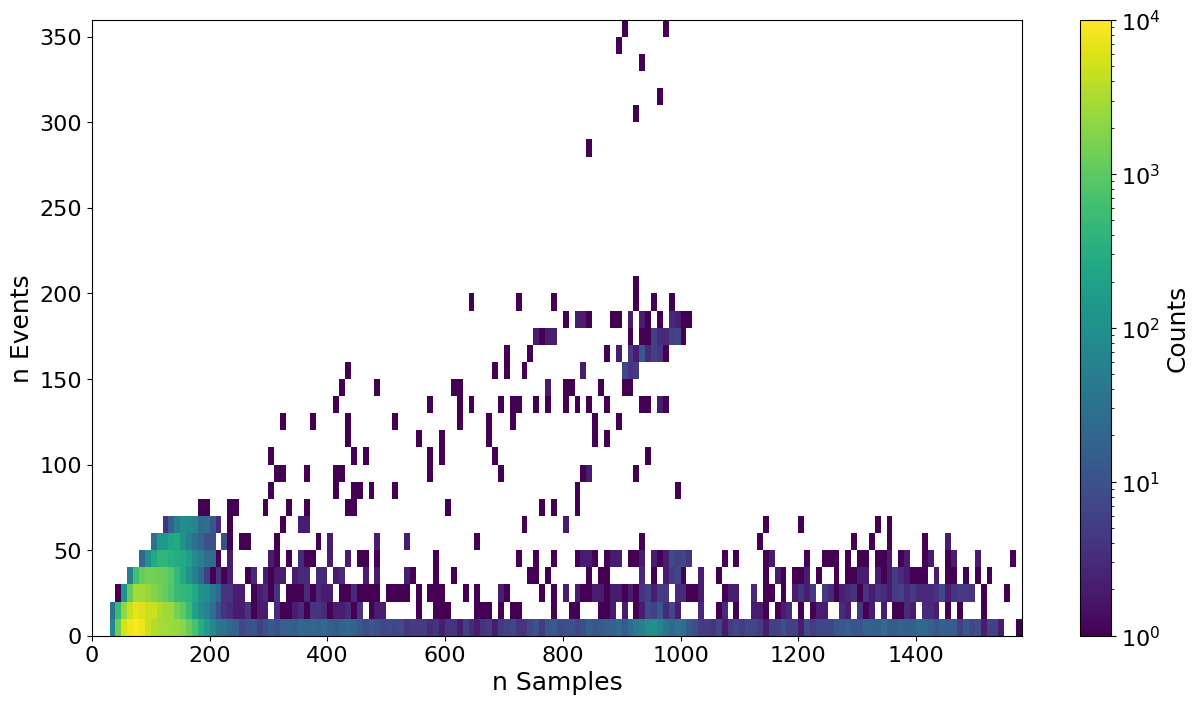

In [53]:
fig, ax = plt.subplots(figsize=(15, 8))
# ax.scatter(n_samples_lc, n_events, alpha=0.25, s=4)
hist = ax.hist2d(n_samples_lc_all, n_events_all, 
                 bins=[np.arange(0, n_samples_lc_all.max()+10, 10), 
                       np.arange(0, n_events_all.max()+10, 10)], 
                 norm=LogNorm())

colorbar = plt.colorbar(hist[3], ax=ax)
colorbar.set_label('Counts', fontsize=18)
colorbar.ax.tick_params(labelsize=16)

# ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel("n Samples", fontsize=18)
ax.set_ylabel("n Events", fontsize=18)
ax.tick_params(labelsize=16)
# ax.set_xlim((0, 250))
# ax.set_ylim((0, 100))
# ax.set_xlim((0, 100))
fig.savefig(f"{fig_dir}n_events_n_samples.png")
plt.show(fig)

/tmp/ipykernel_134998/2300249597.py:4: RuntimeWarning: invalid value encountered in divide
  ax.bar(n_samples_x, n_bright_y / n_samples_y, width=1)


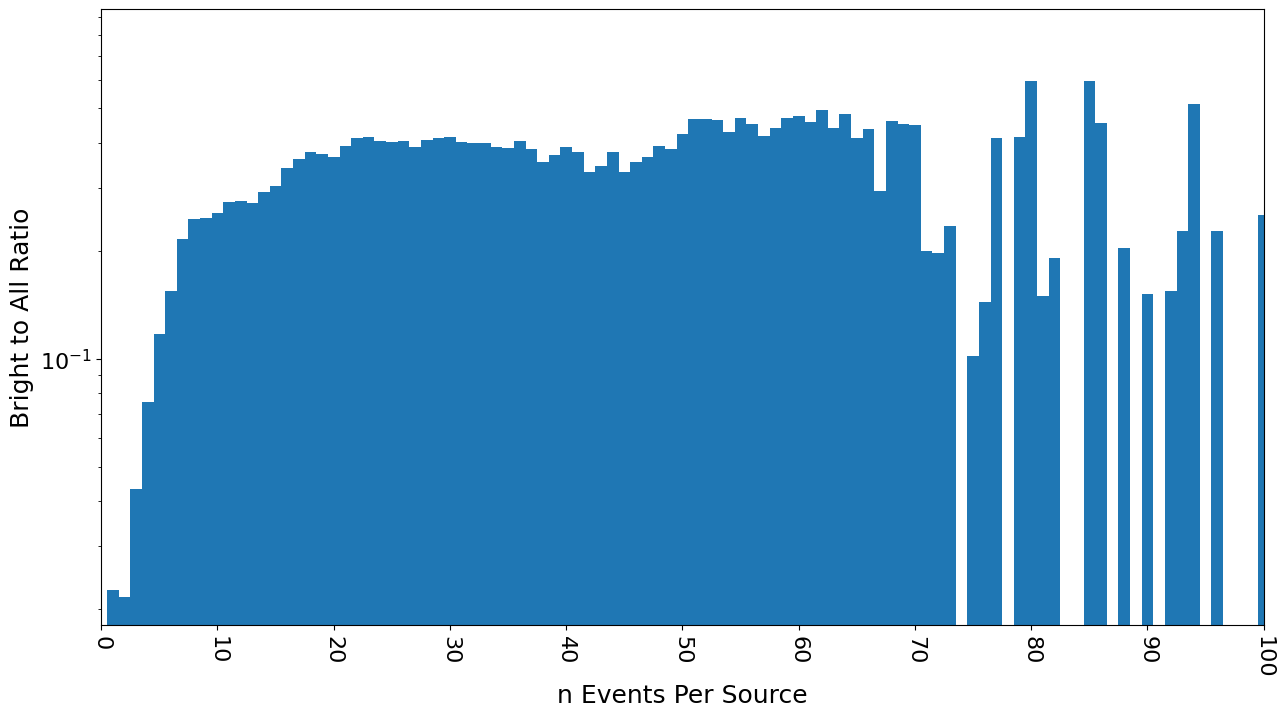

In [88]:
fig, ax = plt.subplots(figsize=(15, 8))
x_ticks = n_samples_x[::10]

ax.bar(n_samples_x, n_bright_y / n_samples_y, width=1)
# ax.plot(n_samples_x, normalizing_curve, color="tab:orange")
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=-90)
ax.set_xlim((x_ticks.min(), x_ticks.max()))
# ax.legend(loc="upper right", fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n Events Per Source", fontsize=18)
ax.set_ylabel("Bright to All Ratio", fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}events_per_source_hist.png")
plt.show(fig)

In [115]:
(n_events_freq_df["all"] * n_events_freq_df["all"].index).sum() / n_events_freq_df["all"].sum()

13.199471840391999

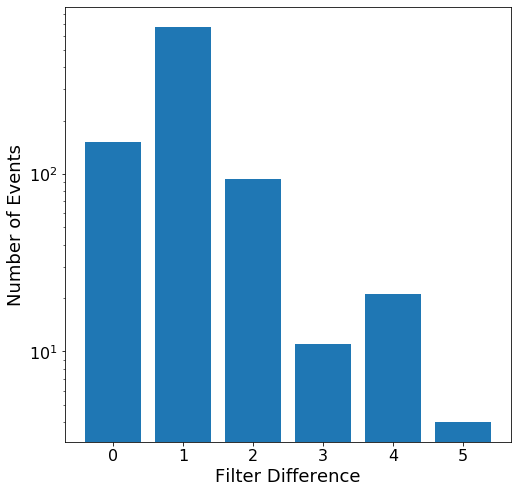

In [34]:
filter_diffs_hist = filter_diffs.value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(filter_diffs_hist.index, filter_diffs_hist)
ax.set_yscale("log")
ax.set_xlabel("Filter Difference", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}filter_difference_hist.png")
plt.show(fig)

In [51]:
filter_seq_count = results_df.groupby(by="filters").t_start.agg("count")

mask_two_sample_results = results_df["n_bright"] > 1
many_bright_ids = results_df.loc[results_df["n_bright"] > 9].index.get_level_values(0)

two_sample_ids = results_df.loc[mask_two_sample_results].index.get_level_values(0)
mask_two_sample = lc_df["objectid"].isin(two_sample_ids)

achromatic_ids = results_df.loc[results_df["achromatic"]].index.get_level_values(0)
mult2_ids = results_df.loc[results_df["multiplicity_2"]].index.get_level_values(0)
n_achromatic = len(achromatic_ids)

mask_achromatic = lc_df["objectid"].isin(achromatic_ids)
mask_bright = lc_df["cluster_label"] == 0
mask_mult2 = lc_df["objectid"].isin(mult2_ids)

bright_lc = lc_df.loc[mask_bright & mask_two_sample]
bright_achromatic_lc = lc_df.loc[mask_achromatic & mask_bright]
bright_achromatic_mult2_lc = lc_df.loc[mask_achromatic & mask_bright & mask_mult2]

flux_double = -2.5 * np.log10(2)

dmag_bins = np.linspace(-2.5, 0, num=26)
bright_achromatic = lc_df.loc[mask_achromatic & mask_bright]

mean_err = bright_achromatic["magerr_auto"].mean()
sigma_err = bright_achromatic["magerr_auto"].std()

achromatic_results = results_df.loc[results_df["achromatic"]]
achromatic_mult2_results = results_df.loc[results_df["achromatic"] & results_df["multiplicity_2"]]

n_distribution = results_df.loc[mask_two_sample_results].groupby(by="n_bright").filters.agg("count")
n_achromatic_distribution = achromatic_results.groupby(by="n_bright").filters.agg("count")
n_achromatic_mult2_distribution = achromatic_mult2_results.groupby(by="n_bright").filters.agg("count")

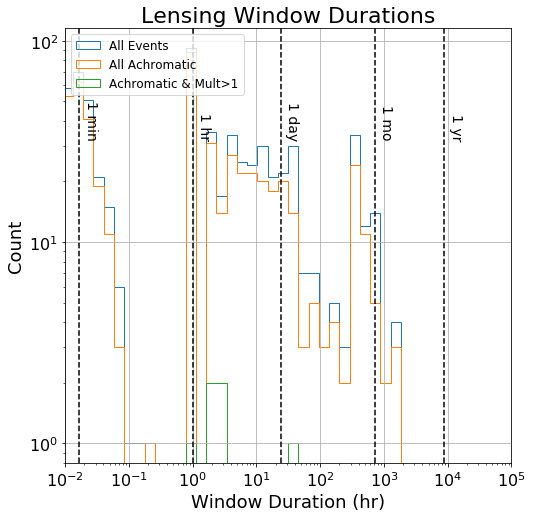

In [45]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
finite_delta_t = np.isfinite(results_df["delta_t"].values)
bins = np.geomspace(results_df.loc[finite_delta_t, "delta_t"].min(), results_df.loc[finite_delta_t, "delta_t"].max() + 1, num=40)

fig, ax = plt.subplots(figsize=(8, 8))
results_df.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, ylabelsize=16, 
                label="All Events", histtype="step")

achromatic_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                        ylabelsize=16, label="All Achromatic", histtype="step")

achromatic_mult2_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                              ylabelsize=16,  label="Achromatic & Mult>1",  histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((1e-2, 1e5))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.75)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations.png")
plt.close(fig)

In [46]:
len(results_df), sum(results_df["achromatic"]), sum(results_df["multiplicity_2"])

(958, 806, 30)

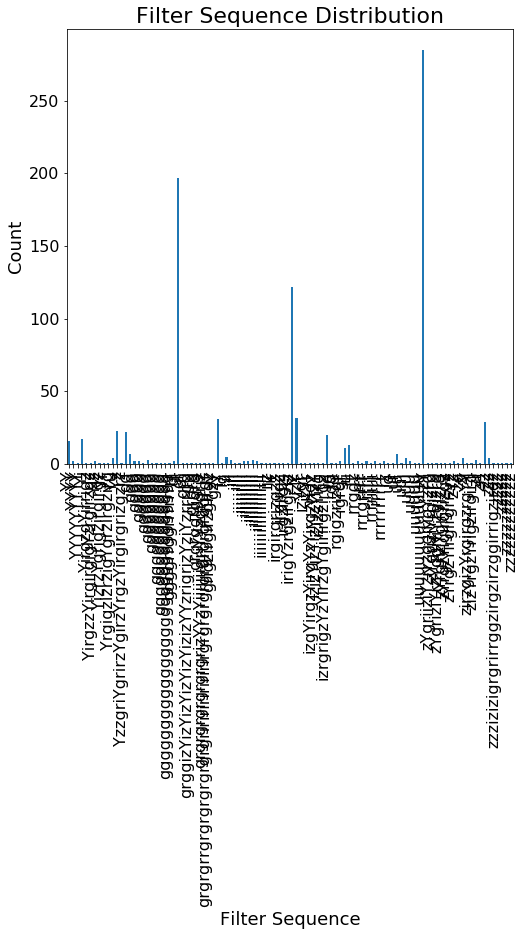

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
filter_seq_count.plot.bar(ax=ax)
ax.set_xlabel("Filter Sequence", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Filter Sequence Distribution", fontsize=22)
ax.tick_params(labelsize=16)
# ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha="right")
# ax.grid(visible=True)
plt.show(fig)
# fig.savefig(f"{fig_dir}filter_category_bar.png")
plt.close(fig)

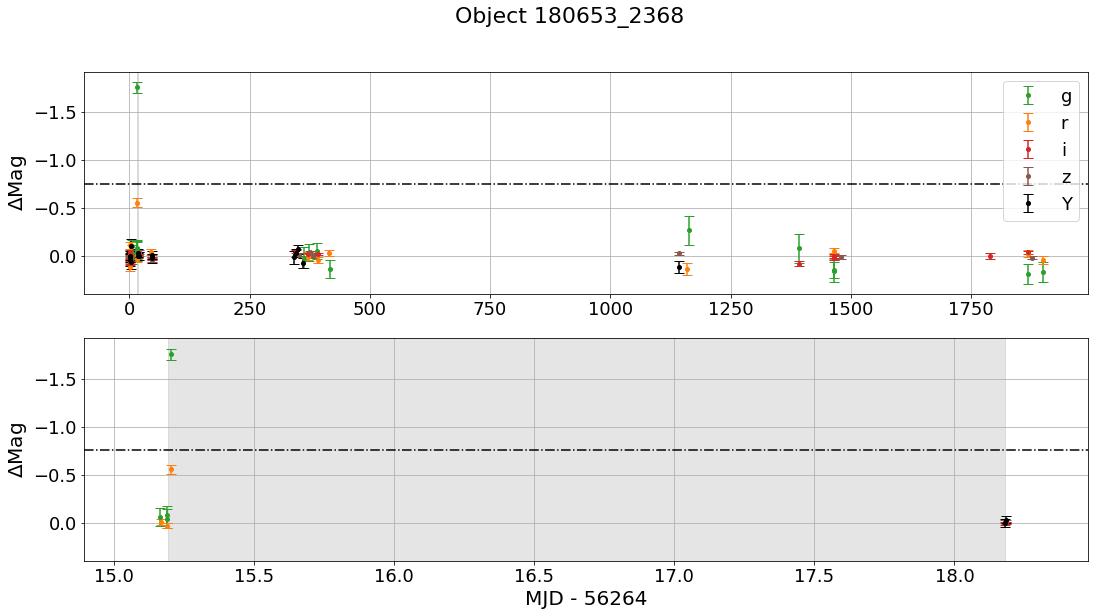

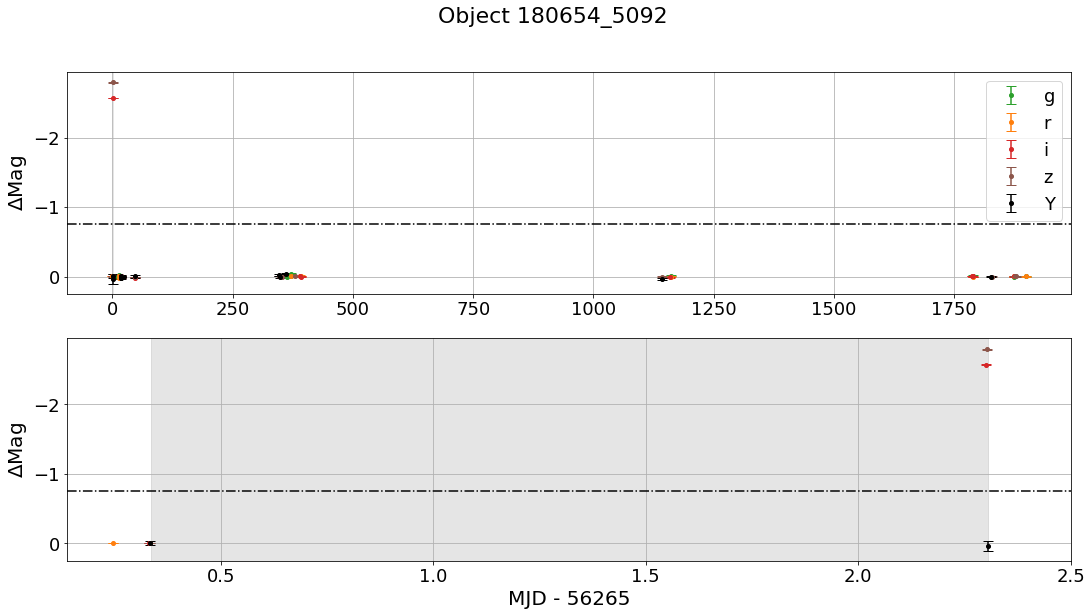

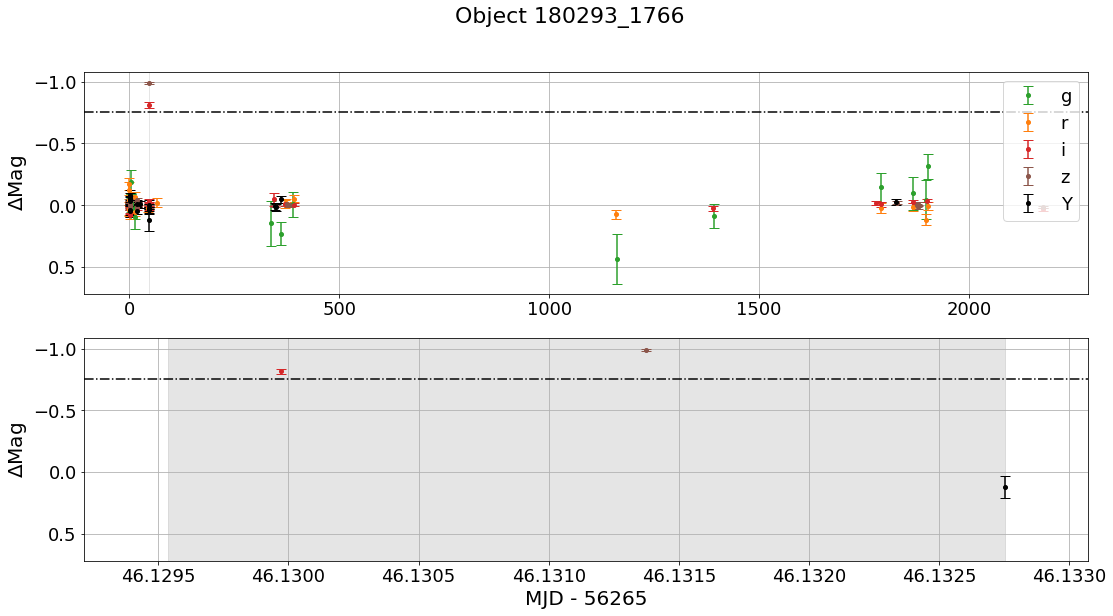

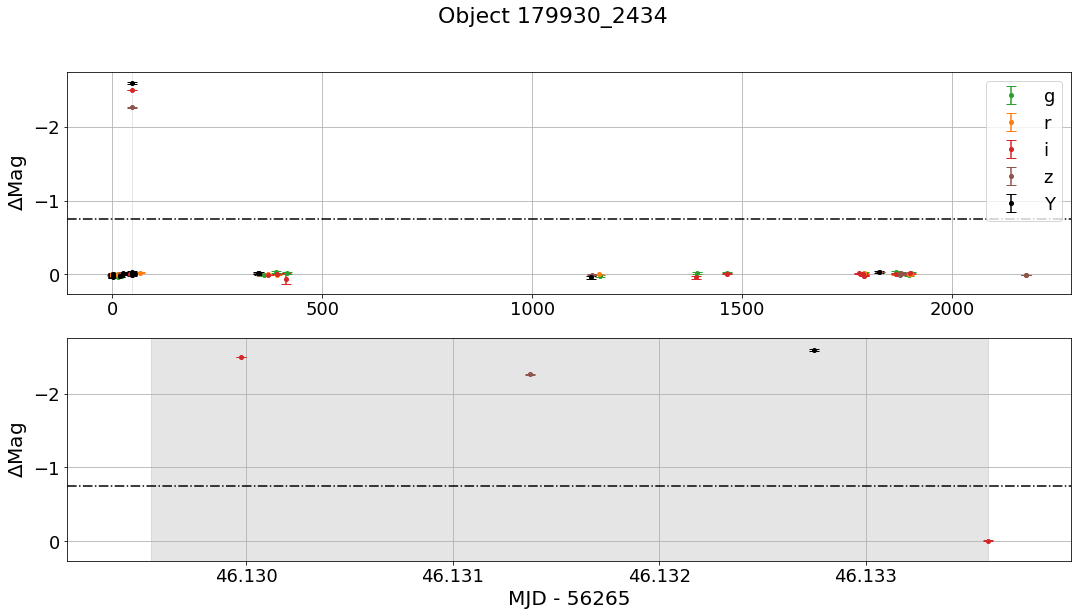

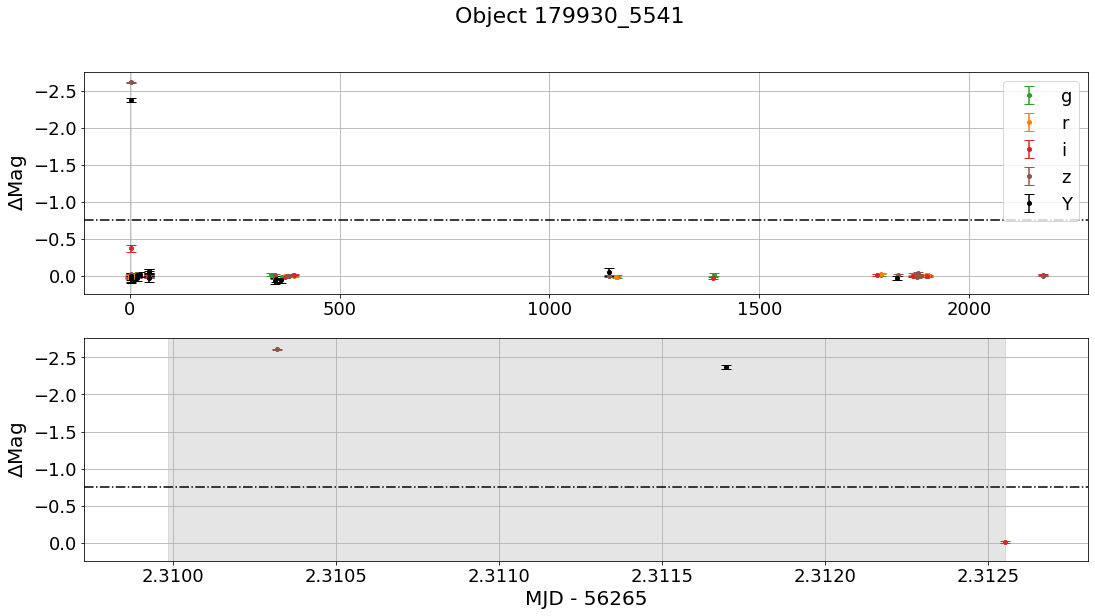

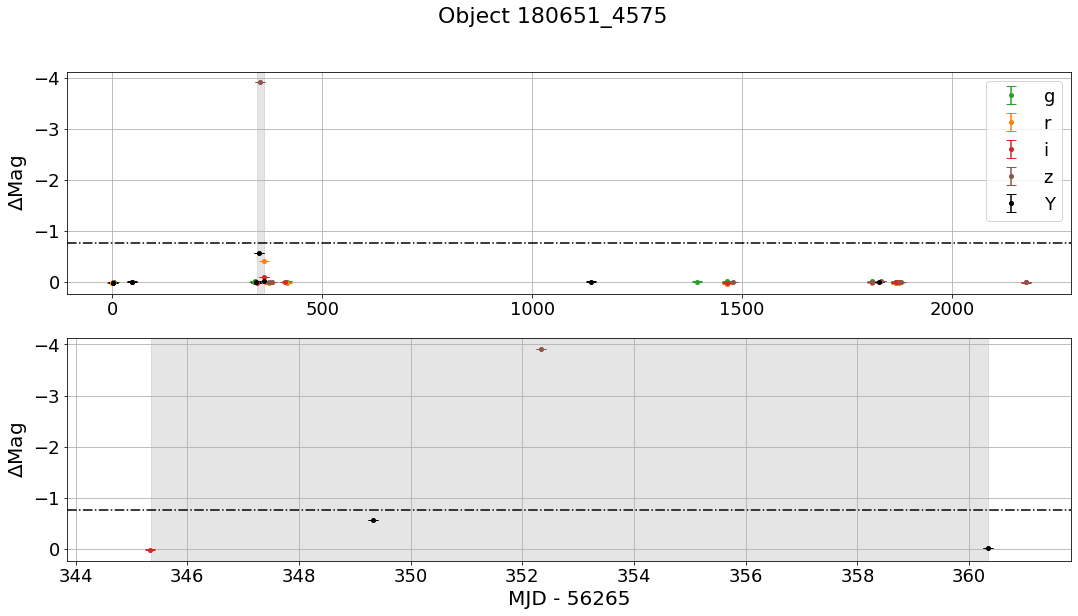

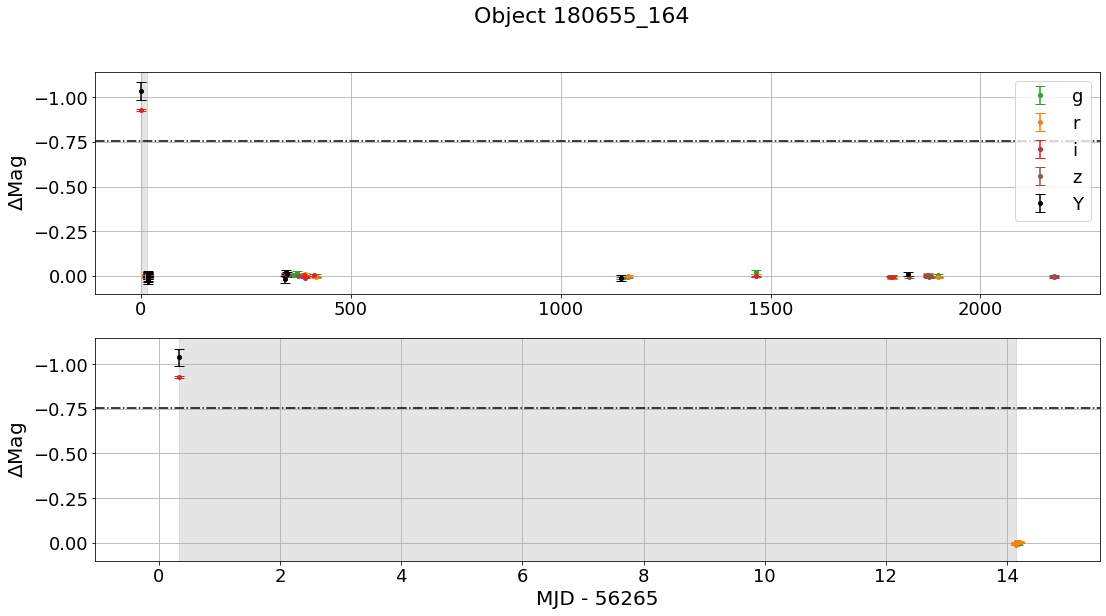

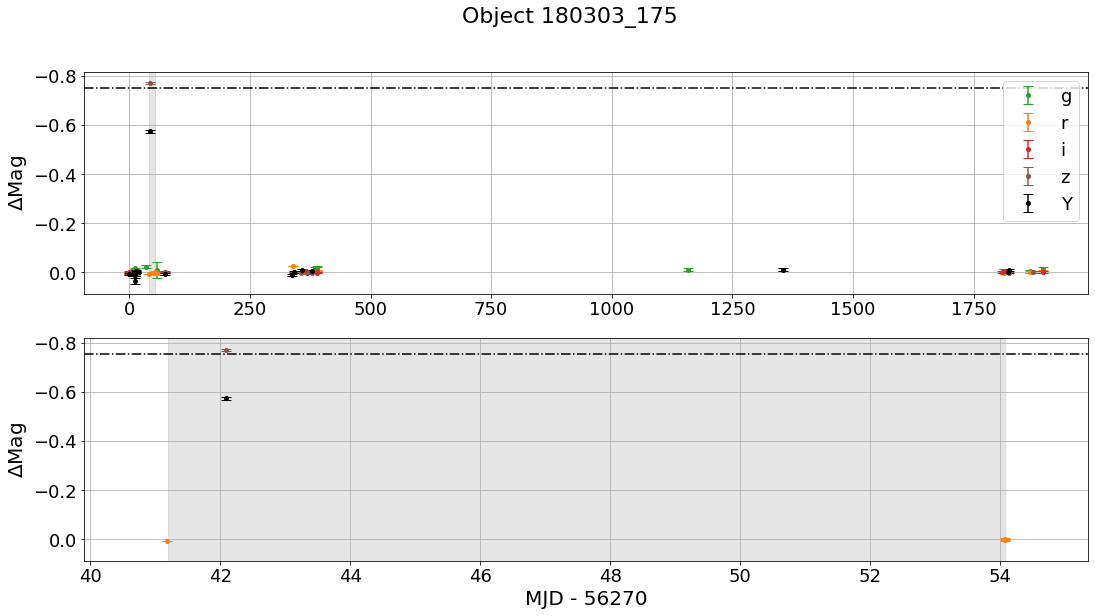

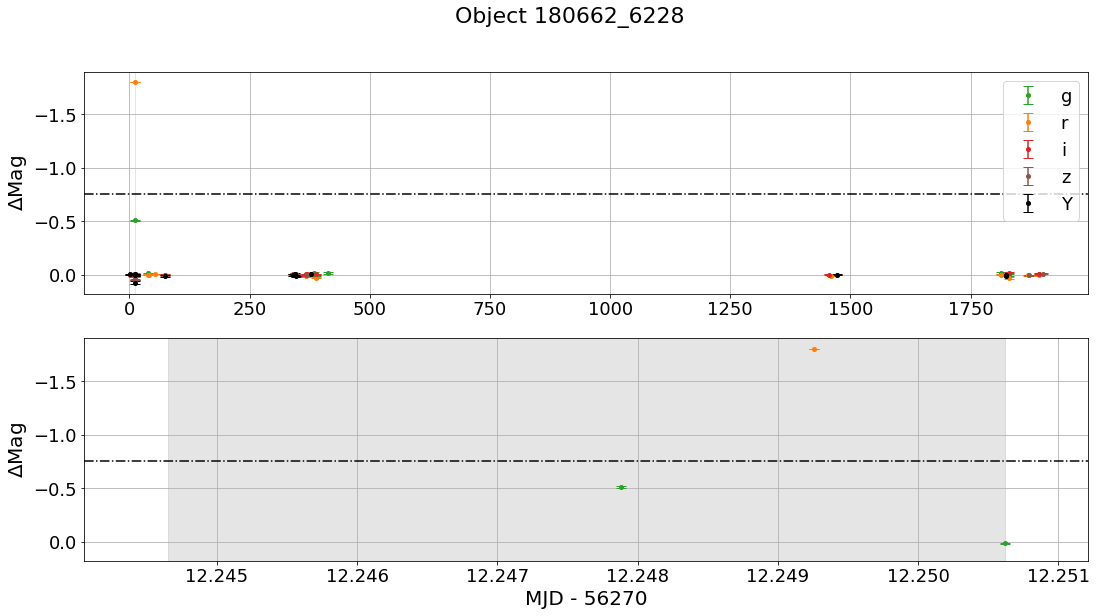

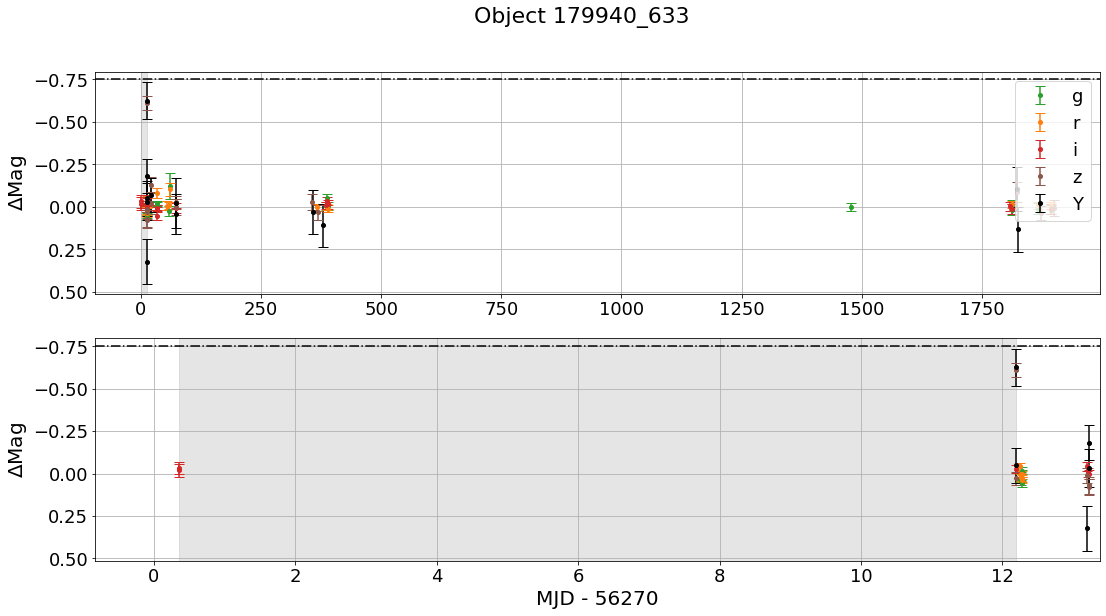

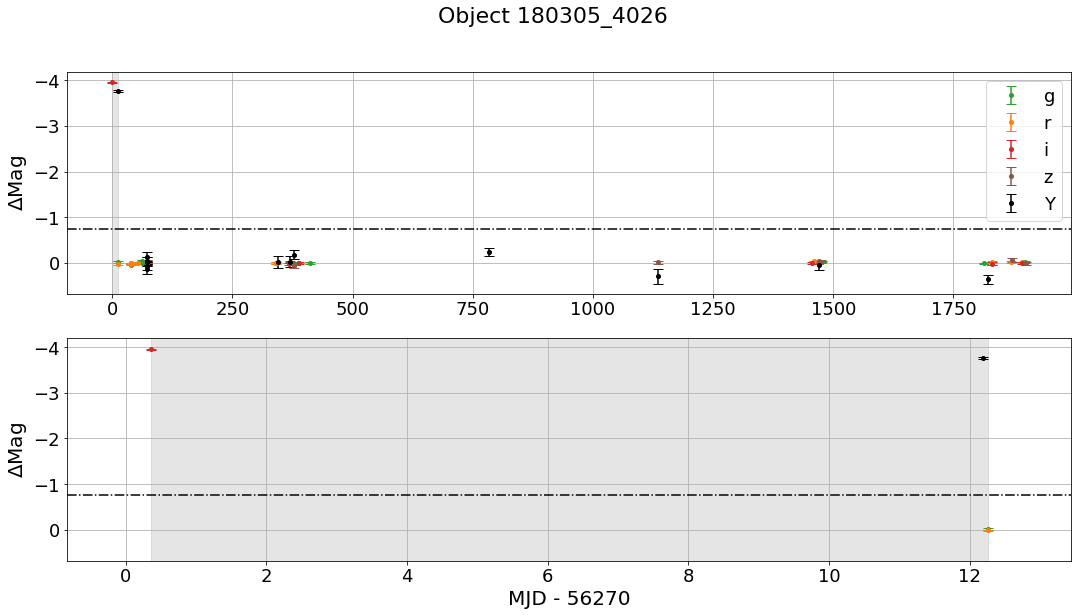

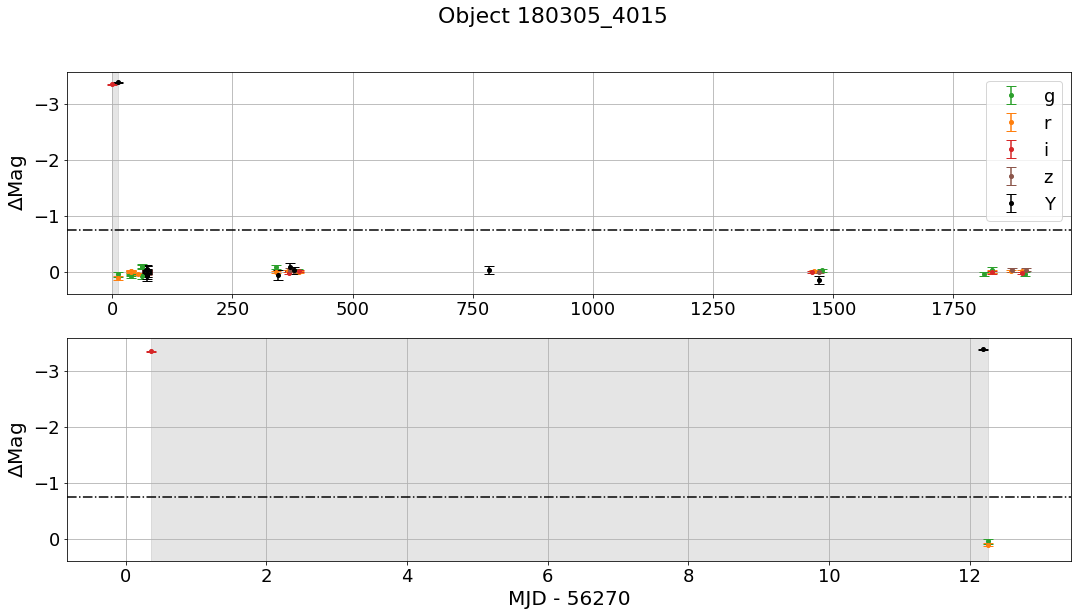

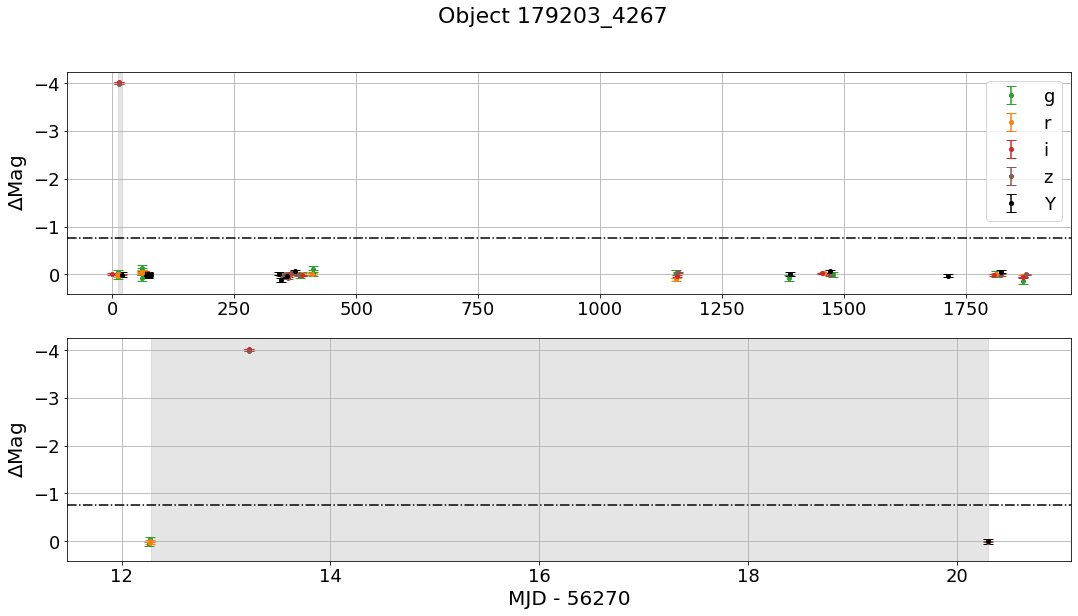

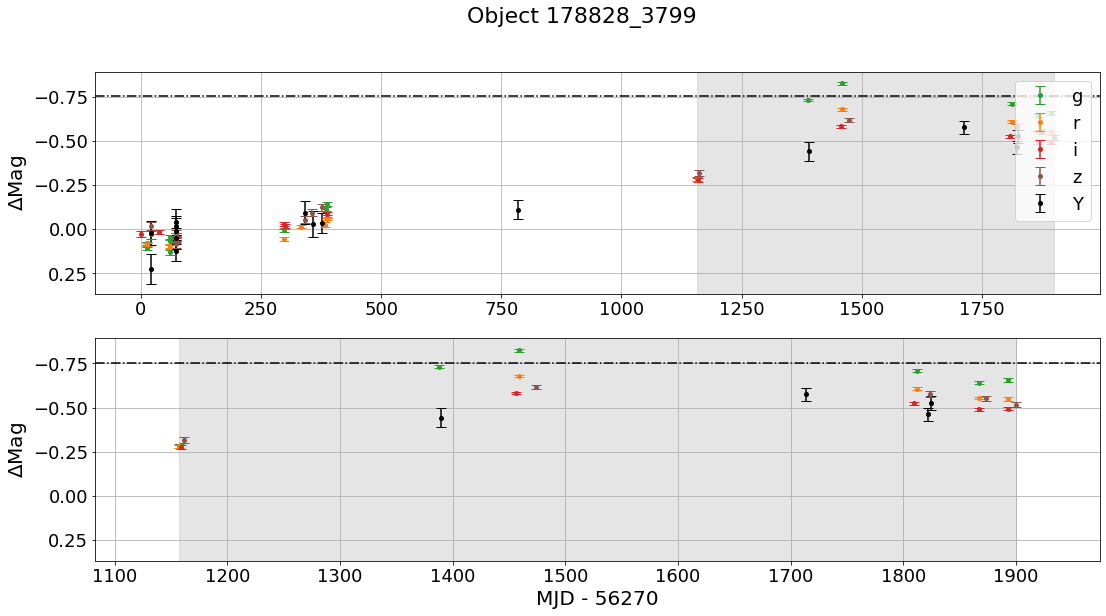

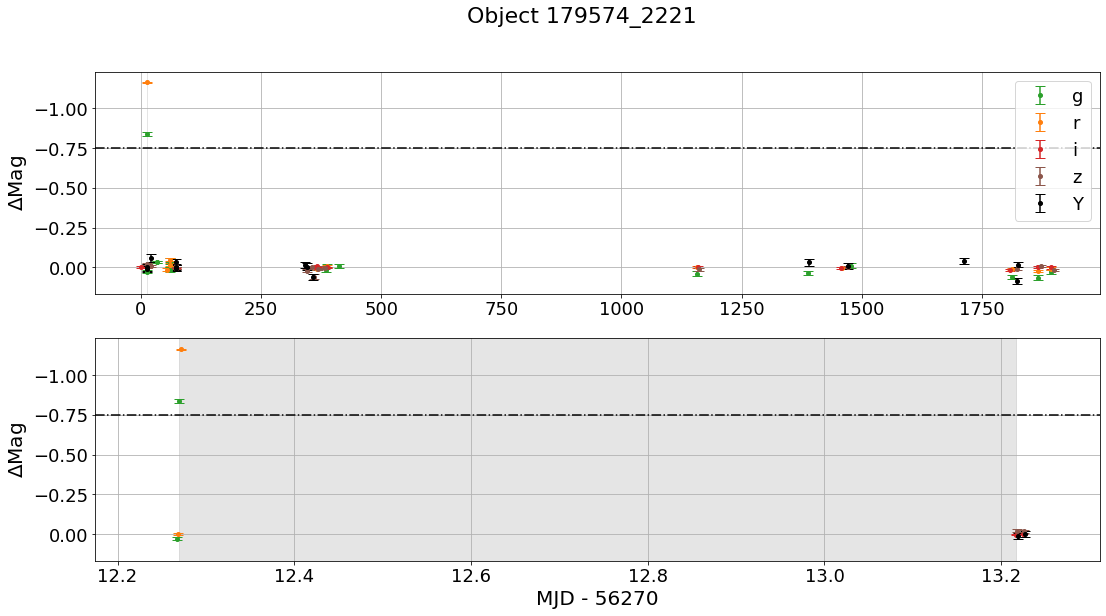

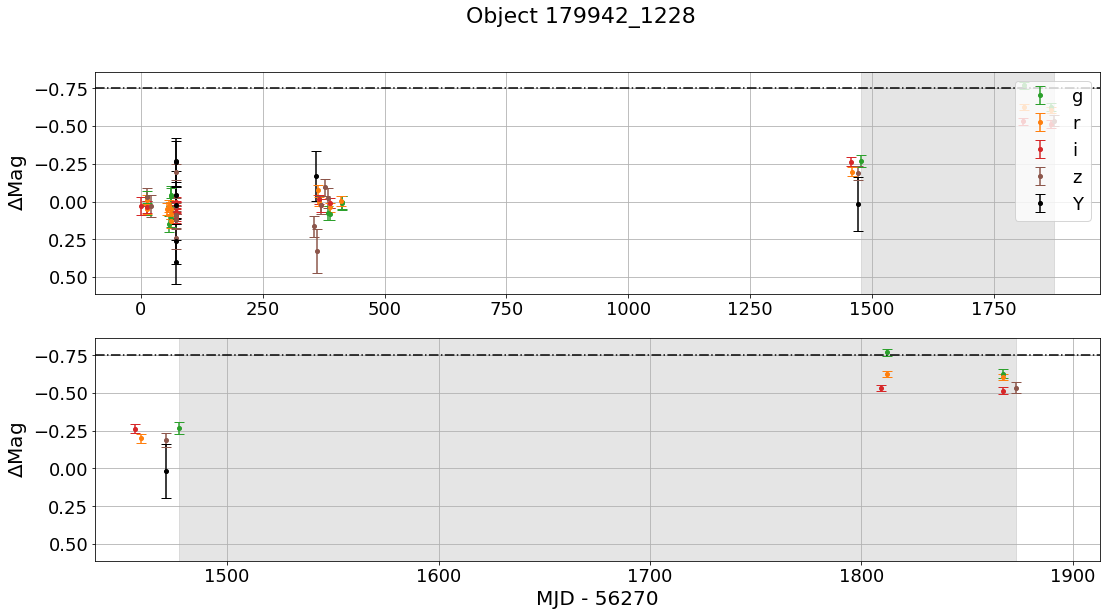

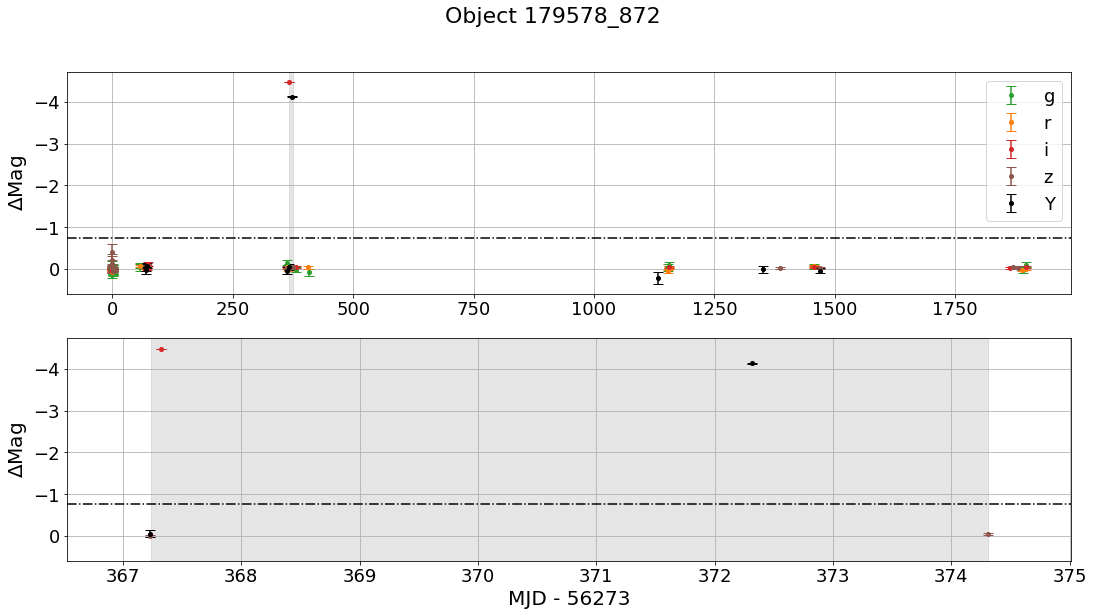

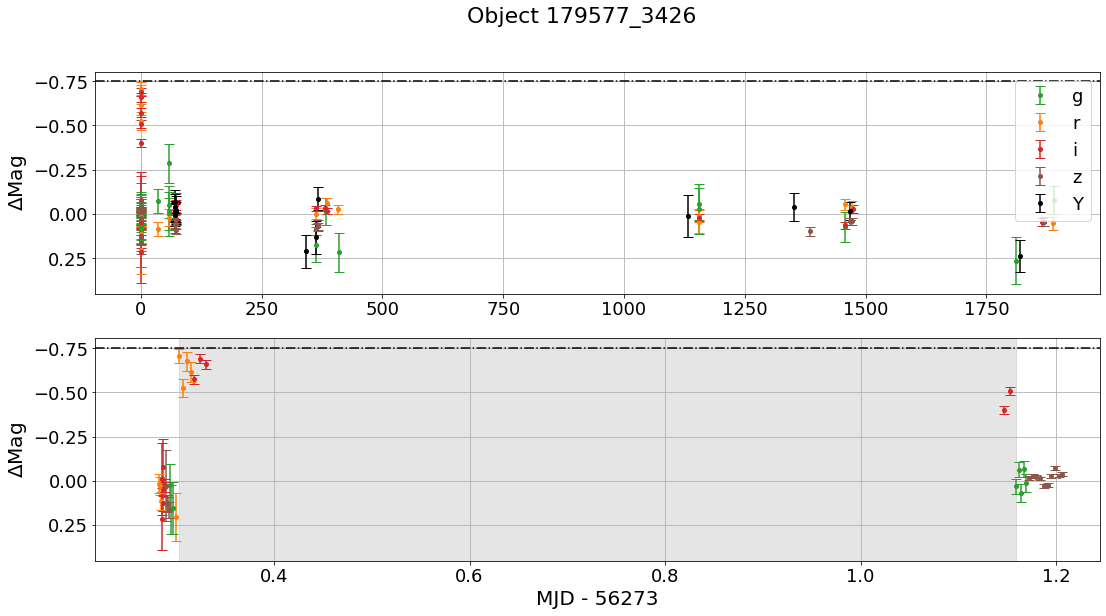

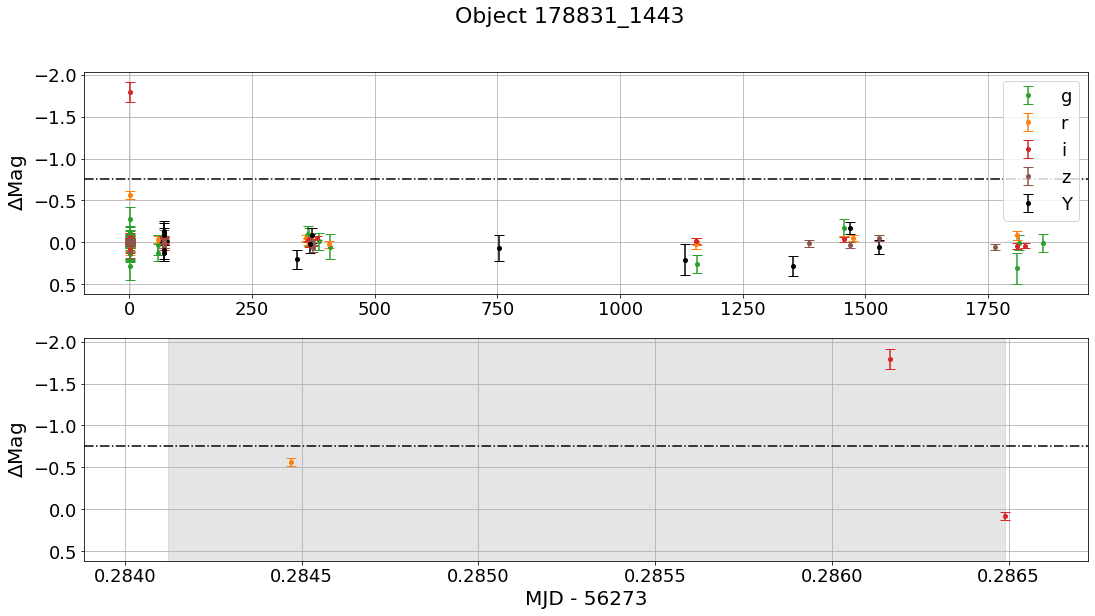

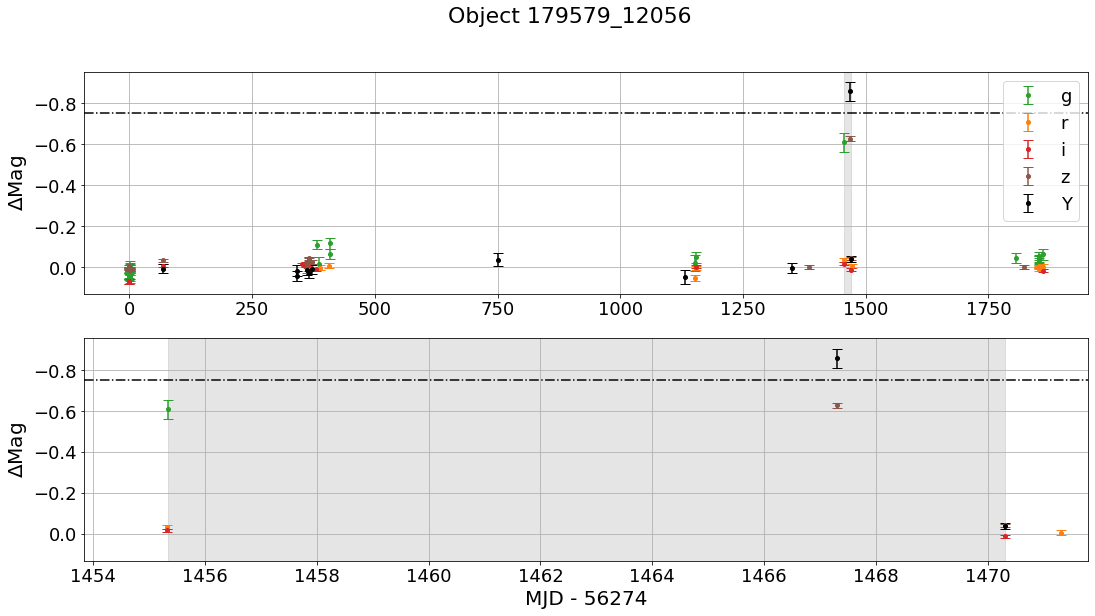

In [56]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])

for oid in achromatic_ids[:20]:
    fig, axes = plt.subplots(2, 1, figsize=(18, 9))
    row = results_df.loc[(oid, 0)]
    ev_start, ev_end = row["t_start"], row["t_end"]
    m_id = lc_df["objectid"] == oid

    if ~np.isfinite(ev_start):
        ev_start = lc_df.loc[m_id, "mjd"].min()
    if ~np.isfinite(ev_end):
        ev_end = lc_df.loc[m_id, "mjd"].max()
    t_delta = ev_end - ev_start
    min_mjd = int(lc_df.loc[m_id, "mjd"].min())

    for f, c in zip(filters, colors):
        m_f = lc_df["filter"] == f
        lc_full = lc_df.loc[m_id & m_f]

        if len(lc_full) > 0:
            axes[0].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None", label=f)
            axes[1].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")

    for ax in axes:
        ax.set_ylabel(r'$\Delta$Mag', fontsize=20)
        ax.tick_params(labelsize=18)
        ax.invert_yaxis()
        ax.grid(visible=True)
        barlims = (ev_start - min_mjd, ev_end - min_mjd)
        ax.axvspan(barlims[0], barlims[1], alpha=0.2, color="tab:gray")
        ax.axhline(flux_double, color='k', linestyle="-.")
        
    legend = axes[0].legend(fontsize=18, loc="upper right")
    axes[1].set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    t_lims = ((ev_start - 0.1 * t_delta) - min_mjd, (ev_end + 0.1 * t_delta) - min_mjd)
    axes[1].set_xlim(t_lims)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{oid}_lightcurve_baseline_subtracted.png")
    plt.close(fig)

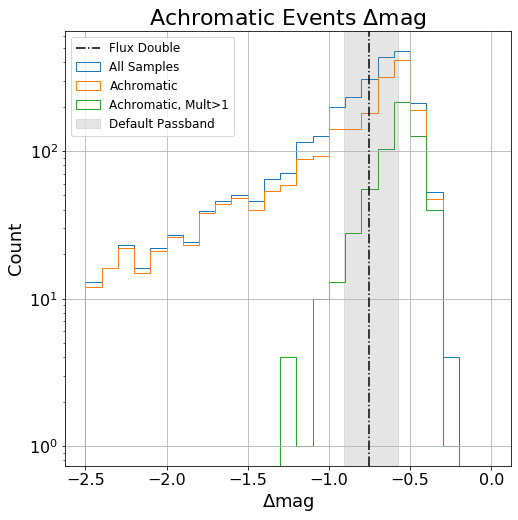

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
bright_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="All Samples")
bright_achromatic_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic")
bright_achromatic_mult2_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic, Mult>1")
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.axvspan(-2.5 * np.log10(2.3), -2.5 * np.log10(1.7), alpha=0.2, 
           color="tab:gray", label="Default Passband")
ax.axvline(-2.5 * np.log10(2), color='k', ls="-.", label="Flux Double")
ax.set_yscale("log")
ax.tick_params(labelsize=16)
ax.legend(loc="upper left", fontsize=12)
ax.set_title(r"Achromatic Events $\Delta$mag", fontsize=22)
plt.show(fig)
# fig.savefig(f"{fig_dir}achromatic_events_deltamag.png")
plt.close(fig)

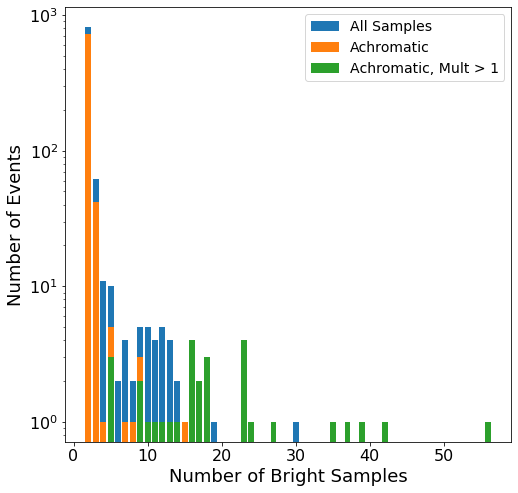

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(n_distribution.index, n_distribution, label="All Samples")
ax.bar(n_achromatic_distribution.index, n_achromatic_distribution, label="Achromatic")
ax.bar(n_achromatic_mult2_distribution.index, n_achromatic_mult2_distribution, label="Achromatic, Mult > 1")
ax.set_yscale("log")
ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Number of Bright Samples", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
plt.show(fig)